# BiLSTM with Word2Vec embeddings

## Word2Vec  BiLSTM

In [1]:
import numpy as np

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
import pickle

Do kích thước lớn của data cho word embeddings và để dễ dàng cập nhật trên github, chúng tôi không thêm data vào phần `resources`. Data cho word embeddings có thể lấy tại [đây](https://drive.google.com/drive/folders/1lHf_Q_nuiUHhJWc5efgl_HgfqmWnQvjh?usp=sharing) \
Để dễ dàng huấn luyện, chúng tôi thực hiện chạy mô hình trên nền tảng Kaggle \
Các file phía dưới sẽ cần tủy chỉnh lại đường dẫn tùy theo vị trí lưu file 

Chúng tôi cam đoan các file trên đều hoàn toàn được sinh ra từ tệp dataset gốc của bài toán. Cụ thể: từ file `Word2Vec.ipynb` trong source code này

In [2]:
model = Word2Vec.load("/kaggle/input/word2vec-imdb-dataset/word_embeddings.model")

In [3]:
with open("/kaggle/input/word2vec-imdb-dataset/sentences.pkl", "rb") as f:
    sentences = pickle.load(f)
with open("/kaggle/input/word2vec-imdb-dataset/test_sentences.pkl", "rb") as f:
    test_sentences = pickle.load(f)

In [6]:
with open("/kaggle/input/word2vec-imdb/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("/kaggle/input/word2vec-imdb/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

In [7]:
for sent in sentences:
    for word in sent:
        if word not in model.wv:
            sent.remove(word)

In [8]:
y_train = np.where(y_train == 'negative', 0, 1)
y_test = np.where(y_test == 'negative', 0, 1)

### Loại bỏ các câu văn dài hơn 250 từ

In [9]:
max_length = 0
idx = - 1
test_idx = -1
gle_250 = []
gle_250_test = []
for i in range(len(sentences)):
    if(len(sentences[i]) > 250):
        gle_250.append(i)
    if (len(sentences[i]) > max_length):
        idx= i
        max_length = len(sentences[i])
for j in range(len(test_sentences)):
    if(len(test_sentences[j]) > 250):
        gle_250_test.append(j)
    if (len(test_sentences[j]) > max_length):
        test_idx = j
        max_length = len(sentences[j])
print(max_length)
print(idx)
print(test_idx)
print(len(gle_250))
print(len(gle_250_test))

1377
22493
-1
3050
1400


In [10]:
for i in range(len(gle_250)):
    idx = gle_250[len(gle_250) - 1 - i]
    sentences.pop(idx)
print()
for i in range(len(gle_250_test)):
    idx = gle_250_test[len(gle_250_test) - 1 -  i]
    test_sentences.pop(idx)
print(len(sentences) + len(gle_250))
print(len(test_sentences) + len(gle_250_test))


35000
15000


In [11]:
y_train = np.delete(y_train, gle_250)
y_test = np.delete(y_test, gle_250_test)

In [12]:
max_length = 0
idx = - 1
test_idx = -1
gle_250_new = []
gle_250_test_new = []
for i in range(len(sentences)):
    if(len(sentences[i]) > 250):
        gle_250_new.append(i)
    if (len(sentences[i]) > max_length):
        idx= i
        max_length = len(sentences[i])
for j in range(len(test_sentences)):
    if(len(test_sentences[j]) > 250):
        gle_250_test_new.append(j)
    if (len(test_sentences[j]) > max_length):
        test_idx = j
        max_length = len(sentences[j])
print(max_length)
print(idx)
print(test_idx)
print(len(gle_250_new))
print(len(gle_250_test_new))

250
62
-1
0
0


### Tokenization và xây dựng embedding_matrix

In [13]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(sentences)

X_train = word_tokenizer.texts_to_sequences(sentences)
X_test = word_tokenizer.texts_to_sequences(test_sentences)
print("encode sucessfully")

encode sucessfully


In [14]:
# import pickle
# with open("/kaggle/working/tokenizer.pkl", "wb") as f:
#     pickle.dump(word_tokenizer, f)

In [15]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

33859

In [16]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [17]:
embedding_matrix = np.zeros((vocab_length, 200))
for word, index in word_tokenizer.word_index.items():
    if word in model.wv:
        embedding_vector = model.wv[word]
    else:
        embedding_vector = np.zeros(200)
    embedding_matrix[index] = embedding_vector     
embedding_matrix.shape

(33859, 200)

### Model 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, LayerNormalization
from tensorflow.keras.regularizers import l2

# Redesigned BiLSTM Model with L2 Regularization
BiLSTM = Sequential([
    Embedding(vocab_length, 200, weights=[embedding_matrix], trainable=True),
    
    # First BiLSTM Layer with L2 regularization
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, 
                       kernel_regularizer=l2(0.0001))),
    LayerNormalization(),  # Layer normalization after LSTM layer
    
    # Second BiLSTM Layer with L2 regularization
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3,
                       kernel_regularizer=l2(0.0001))),
    LayerNormalization(),  # Layer normalization after LSTM layer
    
    # Conv1D Layer with L2 regularization
    Conv1D(100, 5, activation='relu', kernel_regularizer=l2(0.0001)),
    LayerNormalization(),  # Layer normalization after Conv1D layer
    
    # GlobalMaxPooling1D Layer
    GlobalMaxPooling1D(),
    
    # Dense Layers with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),  # Fully connected layer
    Dropout(0.3),  # Dropout for regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)) # Output layer for binary classification
])

# Compile the Model
BiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,771,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,771,800 (25.83 MB)

 Trainable params: 6,771,800 (25.83 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

BiLSTM_history = BiLSTM.fit(X_train, y_train,
                            batch_size=1024,
                            epochs=5,
                            verbose=1,
                            validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5275 - loss: 0.9741 - val_accuracy: 0.7538 - val_loss: 0.7698
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6940 - loss: 0.7369 - val_accuracy: 0.8677 - val_loss: 0.4791
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8419 - loss: 0.5153 - val_accuracy: 0.8920 - val_loss: 0.3918
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8841 - loss: 0.4207 - val_accuracy: 0.8942 - val_loss: 0.3759
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9043 - loss: 0.3699 - val_accuracy: 0.8997 - val_loss: 0.3620


In [56]:
from sklearn.metrics import  classification_report
# Evaluate on test data
test_loss, test_accuracy = BiLSTM.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
y_pred = (BiLSTM.predict(X_test) > 0.5).astype("int32").flatten()

print(classification_report(y_test, y_pred))


425/425 ━━━━━━━━━━━━━━━━━━━━ 106s 249ms/step - accuracy: 0.9029 - loss: 0.3556
Test Loss: 0.3604, Test Accuracy: 0.9018
425/425 ━━━━━━━━━━━━━━━━━━━━ 101s 236ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.90      6772
           1       0.93      0.87      0.90      6828

    accuracy                           0.90     13600
   macro avg       0.90      0.90      0.90     13600
weighted avg       0.90      0.90      0.90     13600



#### Lưu model

In [55]:
import pickle
with open("/kaggle/working/bilstm.pkl", "wb") as f:
    pickle.dump(BiLSTM, f)

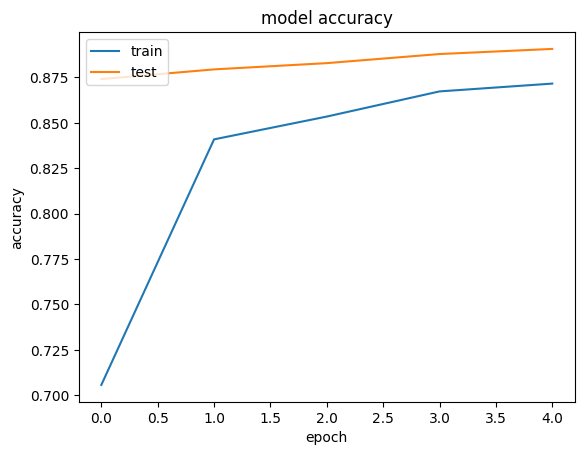

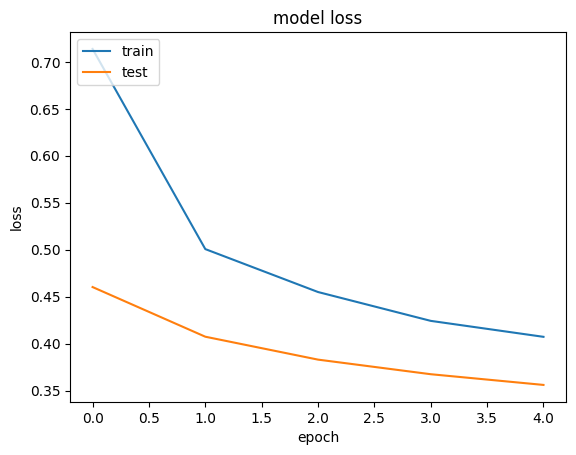

In [51]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(BiLSTM_history.history['accuracy'])
plt.plot(BiLSTM_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

y_test shape: (13600,)
y_pred shape: (13600,)


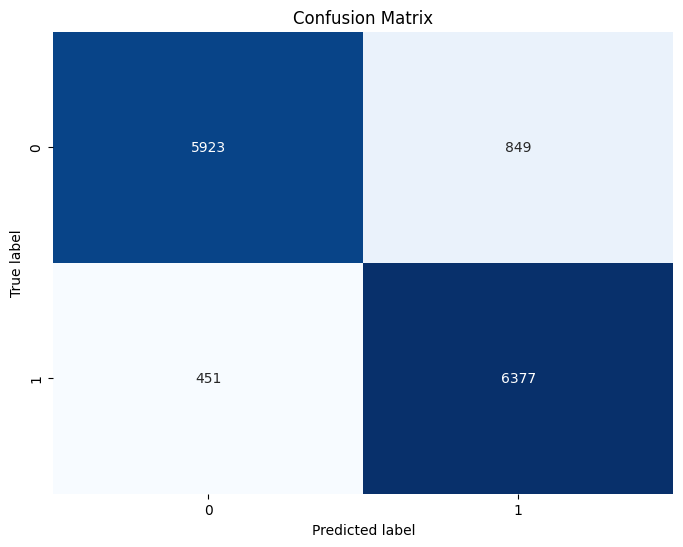

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Kiểm tra kích thước
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

# Tính toán Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()